In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [2]:
data_dir = pathlib.Path('mask')
data_dir

WindowsPath('mask')

In [3]:
import imghdr
from pathlib import Path

image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [4]:
batch_size = 13
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.05,
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 51 files belonging to 2 classes.
Using 49 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 51 files belonging to 2 classes.
Using 10 files for validation.


In [14]:
class_names = train_ds.class_names
class_names

['helmet', 'mask']

In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(13, 180, 180, 3)
(13,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 0.99923754


In [19]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
4/4 [==============================] - 1s 245ms/step - loss: 1.2108 - accuracy: 0.5102 - val_loss: 0.2939 - val_accuracy: 0.9000
Epoch 2/10
4/4 [==============================] - 1s 162ms/step - loss: 0.4933 - accuracy: 0.7551 - val_loss: 0.4065 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 1s 153ms/step - loss: 0.2904 - accuracy: 0.9796 - val_loss: 0.0885 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 1s 148ms/step - loss: 0.1283 - accuracy: 0.9388 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 1s 153ms/step - loss: 0.0259 - accuracy: 1.0000 - val_loss: 0.0168 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 1s 142ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 1s 146ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.5877e-04 - val_accuracy: 1.0000
Epoch 8/10
4/4 [

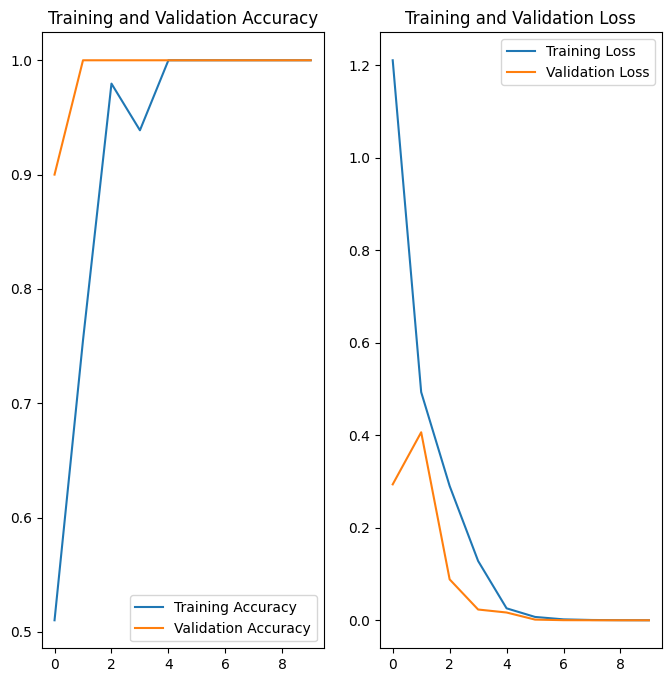

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

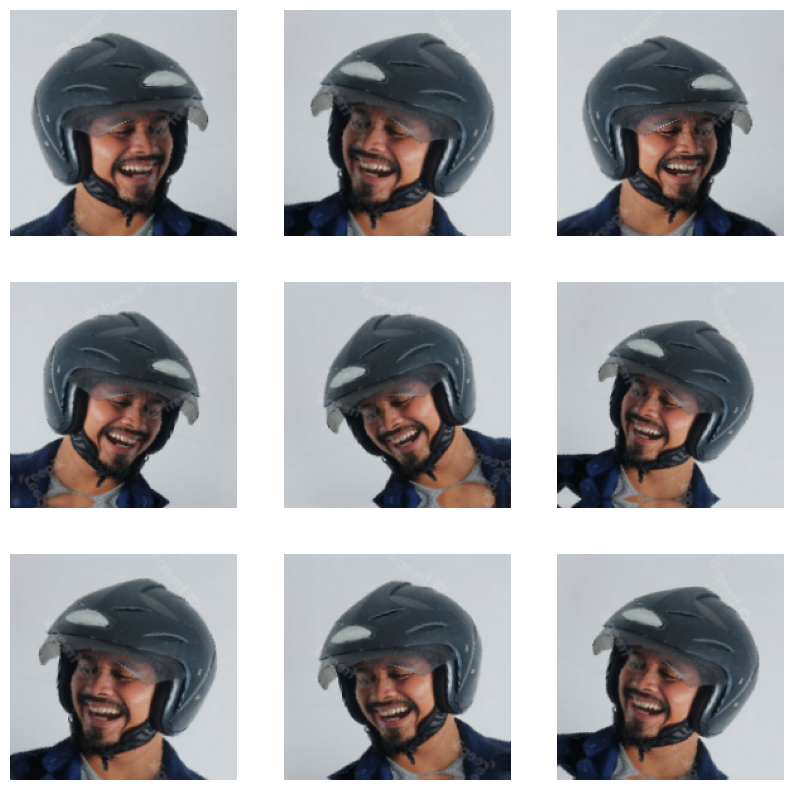

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [26]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [32]:
import os

In [33]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [34]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[cp_callback]
)

Epoch 1/15
4/4 [==============================] - ETA: 0s - loss: 0.6706 - accuracy: 0.6939
Epoch 1: saving model to training_1\cp.ckpt
4/4 [==============================] - 3s 246ms/step - loss: 0.6706 - accuracy: 0.6939 - val_loss: 0.6838 - val_accuracy: 0.7000
Epoch 2/15
4/4 [==============================] - ETA: 0s - loss: 0.5758 - accuracy: 0.7347
Epoch 2: saving model to training_1\cp.ckpt
4/4 [==============================] - 1s 207ms/step - loss: 0.5758 - accuracy: 0.7347 - val_loss: 0.2779 - val_accuracy: 1.0000
Epoch 3/15
4/4 [==============================] - ETA: 0s - loss: 0.4044 - accuracy: 0.7959
Epoch 3: saving model to training_1\cp.ckpt
4/4 [==============================] - 1s 202ms/step - loss: 0.4044 - accuracy: 0.7959 - val_loss: 0.0741 - val_accuracy: 1.0000
Epoch 4/15
4/4 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.8980
Epoch 4: saving model to training_1\cp.ckpt
4/4 [==============================] - 1s 204ms/step - loss: 0.2720 -

In [35]:
model.save("mainModel.h5")

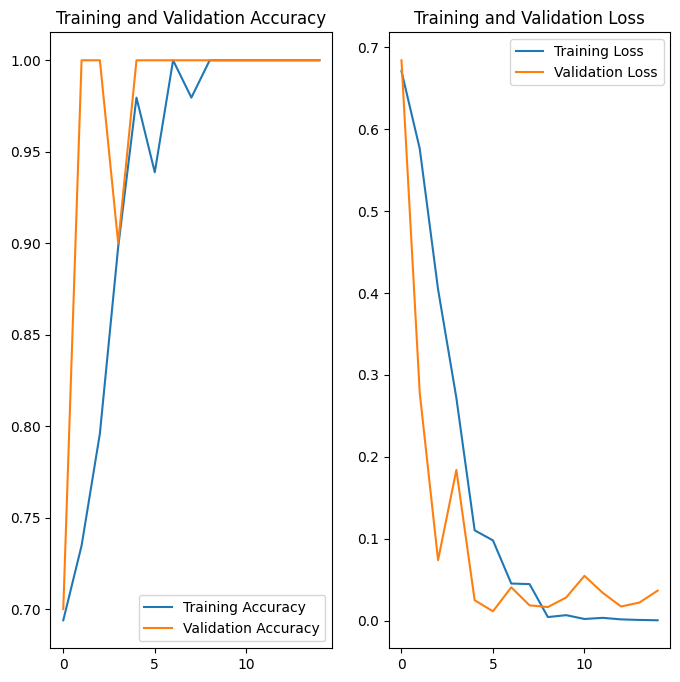

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [111]:
img = tf.keras.utils.load_img(
    "helmets.jpeg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 51ms/step
This image most likely belongs to helmet with a 100.00 percent confidence.
